This test is to know how to calculate fidelity in qutip. QuTiP provides a set of distance metrics for determining how close two density matrix distributions are to each other. Included are the trace distance tracedist, fidelity fidelity, Hilbert-Schmidt distance hilbert_dist, Bures distance bures_dist, Bures angle bures_angle, and quantum Hellinger distance hellinger_dist.

[How to calculate fidelity in QuTip](https://qutip.readthedocs.io/en/stable/guide/guide-states.html#)

fidelity(A, B) : Calculates the fidelity (pseudo-metric) between two density matrices. ( Aqobj : Density matrix or state vector )


In [1]:
from qutip import *

import numpy as np
import matplotlib.pyplot as plt

In [130]:
# Global plotting defaults (feel free to tweak)
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    "font.size": 8,
    'axes.labelsize': 6,
    'axes.titlesize': 7,
    'legend.fontsize': 5,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'lines.linewidth': 0.5,
})
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
x = coherent_dm(5, 1.25)

np.testing.assert_almost_equal(fidelity(x, x), 1)

y = coherent_dm(5, complex(0, 1.25))

np.testing.assert_almost_equal(tracedist(y, x), np.sqrt(1 - fidelity(y, x) ** 2))

z = thermal_dm(5, 0.125)
assert 1 - fidelity(x, z) ** 2 < tracedist(x, z)

In [4]:
print(fidelity(x, x))
print(fidelity(y, x))

1.0000000091688075
0.21252067272724126


 Calculate the gate fidelity : the idea is to evaluate gate fidelity from a reduced set of $d + 1$ input states ———— $\rho_{B,i} = |\phi_i\rang\lang\phi_i|$ with $i = 1,2,\cdots, d$ and $\rho_{TR} = \frac{1}{d}\sum^{d}_{i=1}\sum^{d}_{j=1}|\phi_i\rang\lang\phi_j|$.

 For each input state ( i.e., the density matrix ), we can compute the (state) fidelity 

In [5]:
x = basis(2,0)
y = basis(2,1)
print(fidelity(x, x))
print(fidelity(y, x))

1.0
0.0


## Single Gate Case
We start with the single gate case

In [6]:
# input states for one-qubit case
d = 2
input_state_list = []
input_dm_list = []

state0 = basis(2,0)
input_state_list.append(state0)
input_dm_list.append(state0 * state0.dag())

state1 = basis(2,1)
input_state_list.append(state1)
input_dm_list.append(state1 * state1.dag())

stated = 1 / np.sqrt(2) * ( state0 + state1 )
input_state_list.append(stated)
# input_dm_list.append(stated * stated.dag())
dmd = 1 / 2 * ( state0 * state0.dag() + state1 * state0.dag() + state0 * state1.dag() + state1 * state1.dag() )
input_dm_list.append(dmd)

# some test
print(fidelity(input_dm_list[0], input_dm_list[0]))
print(fidelity(input_dm_list[0], input_dm_list[1]))
print(fidelity(input_dm_list[1], input_dm_list[0]))
print(fidelity(input_dm_list[1], input_dm_list[1]))
print(fidelity(input_dm_list[1], input_dm_list[2]))
print(fidelity(input_dm_list[2], input_dm_list[1]))
print(fidelity(input_dm_list[2], input_dm_list[2]))

1.0
0.0
0.0
1.0
0.7071067811865476
0.7071067811865476
1.0000000000000002


d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


In [7]:
# calculate the state fidelity for different input states
# we are interested in the output states after the noisy and noise-free ( ideal ) versions of the gate, here we take the noise-free gate as X gate
state_fidelity_list = []

gate1 = sigmax()
# gate2 = sigmax() # itself
# gate2 = sigmay()
gate2 = sigmaz()
# gate2 = identity(2)
# gate2 = rand_unitary(d) # random unitary

output_dm1 = None
output_dm2 = None
for idx, input_dm in enumerate(input_dm_list):
  output_dm1 = gate1 * input_dm * gate1.dag()
  output_dm2 = gate2 * input_dm * gate2.dag()
  state_fidelity_list.append(fidelity(output_dm1, output_dm2))

In [8]:
print(state_fidelity_list)
print(sum(state_fidelity_list))

[np.float64(0.0), np.float64(0.0), np.float64(2.1885762410763535e-16)]
2.1885762410763535e-16


In [9]:
# calculate the average gate fidelity with arithmetic mean
fidelity_arith = 1 / ( d + 1 ) * ( sum(state_fidelity_list) )

# calculate the average gate fidelity with modified geometric mean
fidelity_prod = np.prod(state_fidelity_list[:-1])
fidelity_geom = 1 / ( d + 1 ) + (1 - 1 / ( d + 1 )) * state_fidelity_list[-1] * fidelity_prod

# calculate the average gate fidelity with a combined measure of two
lambda_mix = 1 - (1 - fidelity_prod) / (1 - fidelity_prod * state_fidelity_list[-1])
# lambda_mix = fidelity_prod * (1 - state_fidelity_list[-1]) / (1 - fidelity_prod * state_fidelity_list[-1])
fidelity_lambda = lambda_mix * fidelity_geom + (1 - lambda_mix) * fidelity_arith

print(fidelity_arith, fidelity_geom, fidelity_lambda, lambda_mix)

7.295254136921178e-17 0.3333333333333333 7.295254136921178e-17 0.0


In [10]:
np.testing.assert_almost_equal(lambda_mix, fidelity_prod * (1 - state_fidelity_list[-1]) / (1 - fidelity_prod * state_fidelity_list[-1]))

### Test : gate fidelity between X gate and X rotation gate.
- compute different types of gate fidelity : arithmetic mean / modified geometric mean / a combined measure of two / built-in function
- plot these gate fidelity as a function of $\theta$
- compare these gate fidelity

In [ ]:
# angle
num_angle = 200
theta_list = np.linspace(0, 4 * np.pi, num_angle)
x_gate = sigmax()
output_dm1_list = []
for input_dm in input_dm_list:
    output_dm1 = x_gate * input_dm * x_gate.dag()
    output_dm1_list.append(output_dm1)

# compute different types of average gate fidelity
fidelity_arith_list = []
fidelity_geom_list = []
fidelity_lambda_list = []
fidelity_gate_list = []

for idx in range(num_angle):
  cur_angle = theta_list[idx]
  x_rot_gate = gates.rx(cur_angle)

  # get state fidelity for different input states
  state_fidelity_list = []
  output_dm2 = None
  for ii, input_dm in enumerate(input_dm_list):
    output_dm1 = output_dm1_list[ii]
    output_dm2 = x_rot_gate * input_dm * x_rot_gate.dag()
    state_fidelity_list.append(fidelity(output_dm1, output_dm2))
  
  ## compute different types of average gate fidelity
  # arithmetic mean
  fidelity_arith = 1 / ( d + 1 ) * ( sum(state_fidelity_list) )
  fidelity_arith_list.append(fidelity_arith)

  # modified geometric mean
  fidelity_prod = np.prod(state_fidelity_list[:-1])
  fidelity_geom = 1 / ( d + 1 ) + (1 - 1 / ( d + 1 )) * state_fidelity_list[-1] * fidelity_prod
  fidelity_geom_list.append(fidelity_geom)

  # a combined measure of two
  lambda_mix = 1 - (1 - fidelity_prod) / (1 - fidelity_prod * state_fidelity_list[-1])
  fidelity_lambda = lambda_mix * fidelity_geom + (1 - lambda_mix) * fidelity_arith
  fidelity_lambda_list.append(fidelity_lambda)

  # built-in function
  fidelity_gate = average_gate_fidelity(oper=x_rot_gate, target=x_gate)
  fidelity_gate_list.append(fidelity_gate)

Plot the fidelity as function of angle $\theta$ for the rx() gate

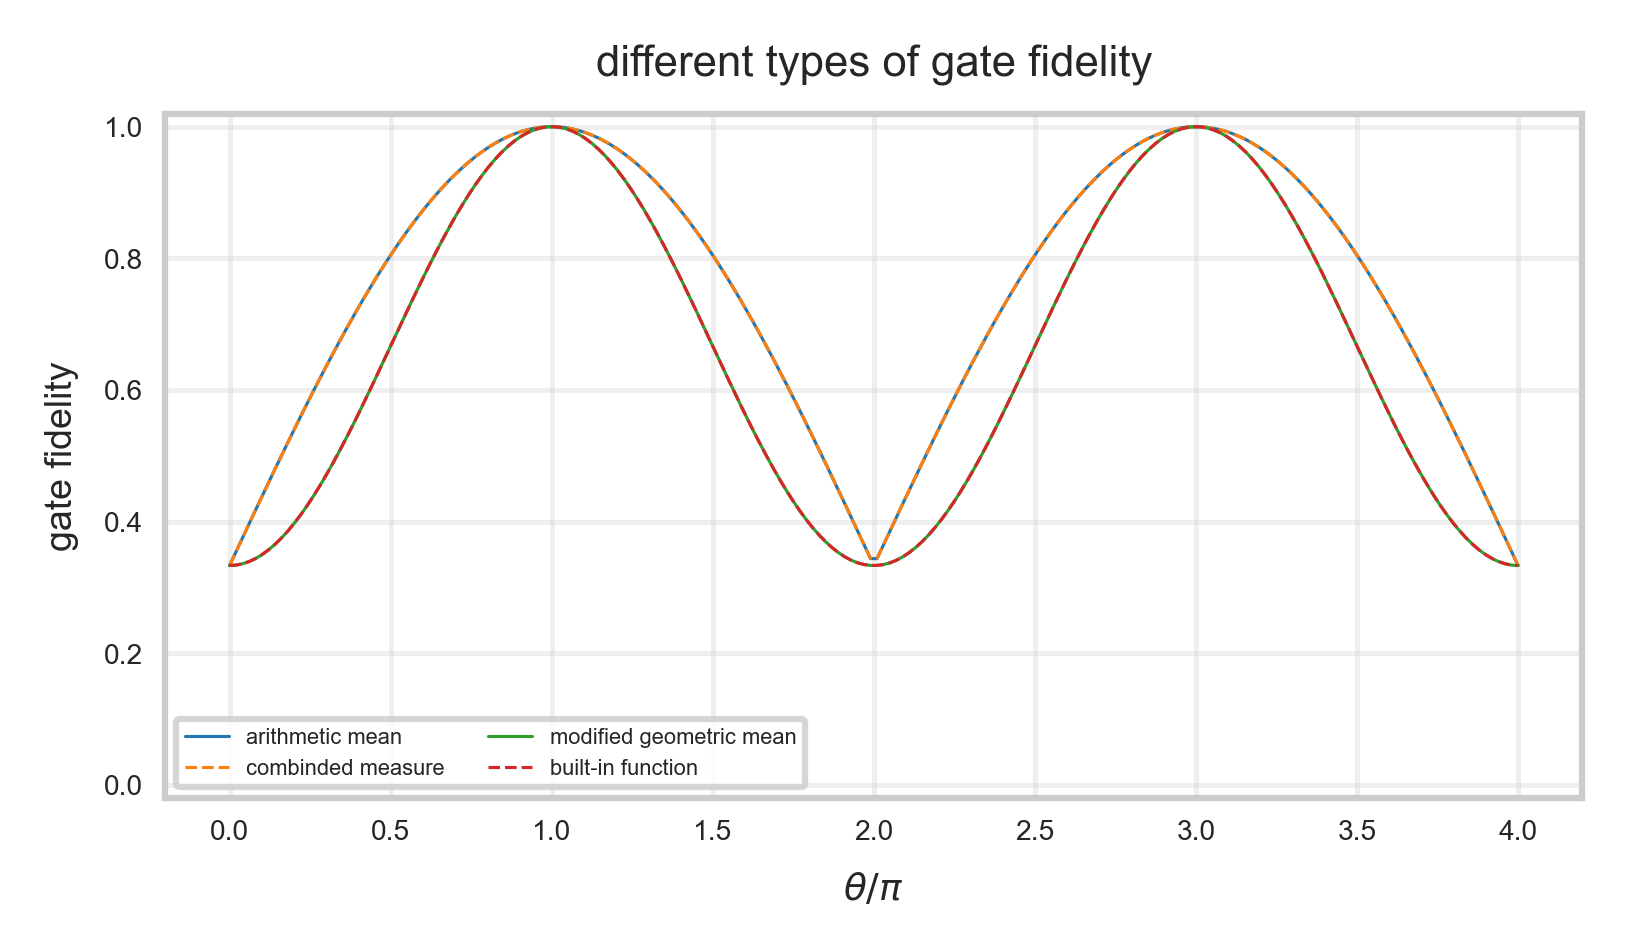

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.0), constrained_layout=True)

theta_mod_list = theta_list / np.pi
ax.plot(theta_mod_list, fidelity_arith_list, label='arithmetic mean', linewidth=0.5)
ax.plot(theta_mod_list, fidelity_lambda_list, label='combinded measure', linestyle='--', linewidth=0.5)

ax.plot(theta_mod_list, fidelity_geom_list, label='modified geometric mean', linewidth=0.5)
ax.plot(theta_mod_list, fidelity_gate_list, label='built-in function', linestyle='--', linewidth=0.5)
ax.grid(True, alpha=0.3)

ax.set(xlabel=r'$\theta / \pi$', ylabel='gate fidelity', title='different types of gate fidelity')
ax.set_ylim(-0.02, 1.02)
ax.legend(ncol=2, frameon=True)
plt.show()

### Test : gate fidelity between X gate and random unitary gate
- compute different types of gate fidelity : arithmetic mean / modified geometric mean / a combined measure of two / built-in function
- compare these gate fidelity

In [14]:
# number of test
num_random = 100
x_gate = sigmax()
output_dm1_list = []
for input_dm in input_dm_list:
    output_dm1 = x_gate * input_dm * x_gate.dag()
    output_dm1_list.append(output_dm1)

# compute different types of average gate fidelity
fidelity_arith_list = []
fidelity_geom_list = []
fidelity_lambda_list = []
fidelity_gate_list = []

for idx in range(num_random):
  rand_gate = rand_unitary(d)

  # get state fidelity for different input states
  state_fidelity_list = []
  output_dm2 = None
  for ii, input_dm in enumerate(input_dm_list):
    output_dm1 = output_dm1_list[ii]
    output_dm2 = rand_gate * input_dm * rand_gate.dag()
    state_fidelity_list.append(fidelity(output_dm1, output_dm2))
  
  ## compute different types of average gate fidelity
  # arithmetic mean
  fidelity_arith = 1 / ( d + 1 ) * ( sum(state_fidelity_list) )
  fidelity_arith_list.append(fidelity_arith)

  # modified geometric mean
  fidelity_prod = np.prod(state_fidelity_list[:-1])
  fidelity_geom = 1 / ( d + 1 ) + (1 - 1 / ( d + 1 )) * state_fidelity_list[-1] * fidelity_prod
  fidelity_geom_list.append(fidelity_geom)

  # a combined measure of two
  lambda_mix = 1 - (1 - fidelity_prod) / (1 - fidelity_prod * state_fidelity_list[-1])
  fidelity_lambda = lambda_mix * fidelity_geom + (1 - lambda_mix) * fidelity_arith
  fidelity_lambda_list.append(fidelity_lambda)

  # built-in function
  fidelity_gate = average_gate_fidelity(oper=rand_gate, target=x_gate)
  fidelity_gate_list.append(fidelity_gate)


d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


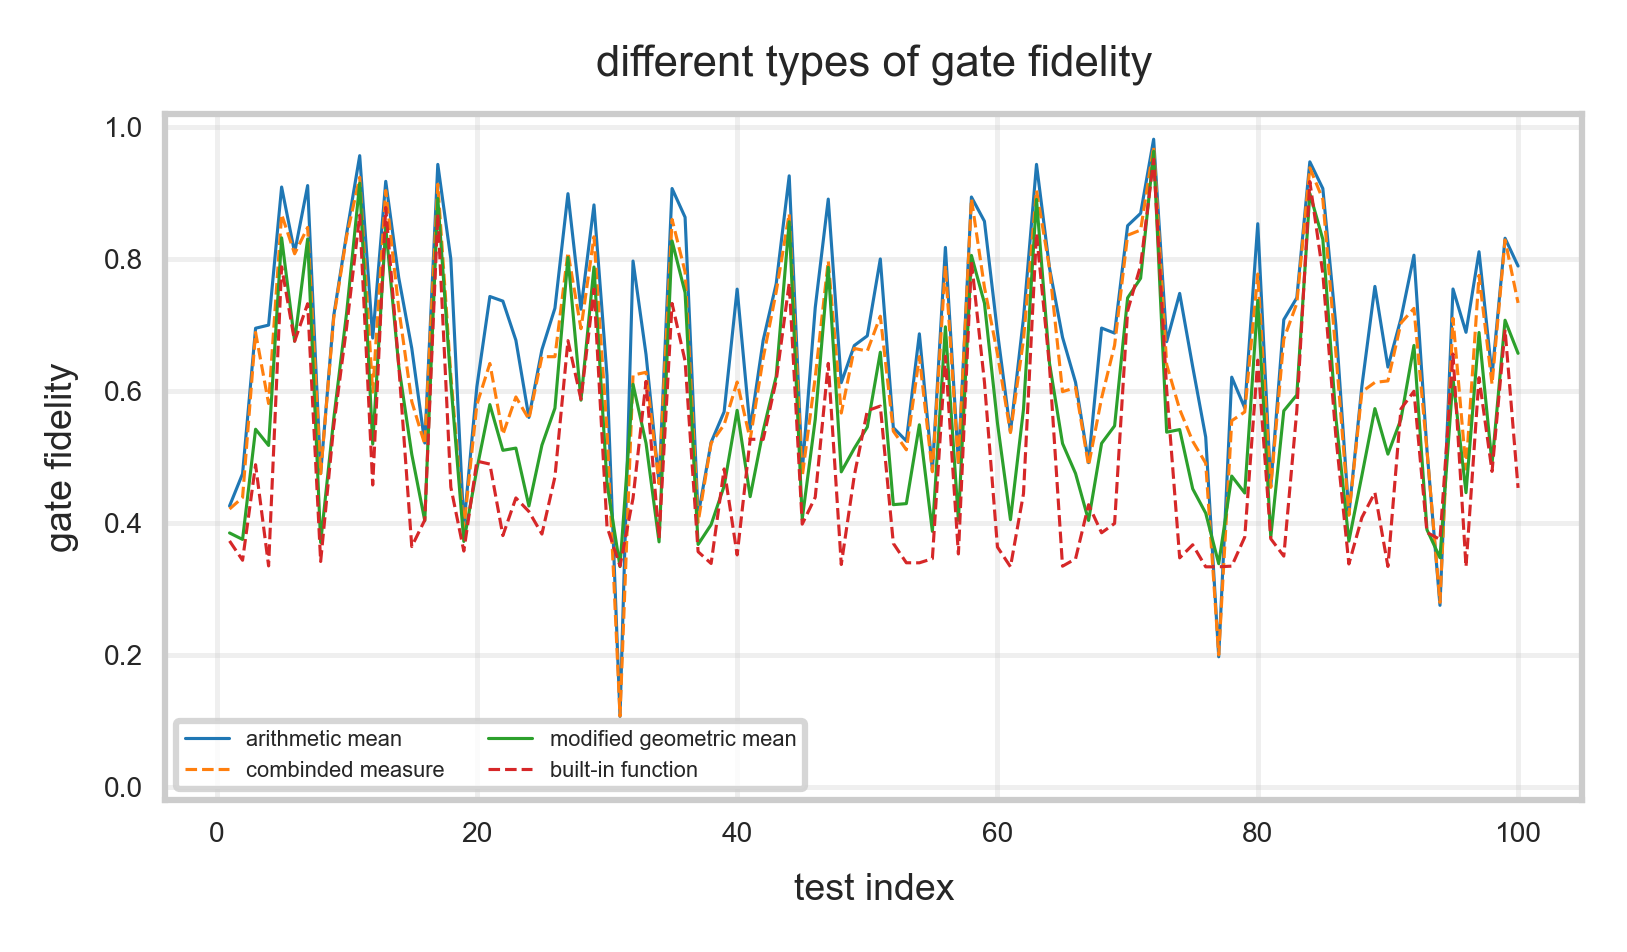

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.0), constrained_layout=True)

xrange_list = np.arange(num_random) + 1
ax.plot(xrange_list, fidelity_arith_list, label='arithmetic mean', linewidth=0.5)
ax.plot(xrange_list, fidelity_lambda_list, label='combinded measure', linestyle='--', linewidth=0.5)

ax.plot(xrange_list, fidelity_geom_list, label='modified geometric mean', linewidth=0.5)
ax.plot(xrange_list, fidelity_gate_list, label='built-in function', linestyle='--', linewidth=0.5)
ax.grid(True, alpha=0.3)

ax.set(xlabel='test index', ylabel='gate fidelity', title='different types of gate fidelity')
ax.set_ylim(-0.02, 1.02)
ax.legend(ncol=2, frameon=True)
plt.show()

## Two Gate Case
We start with the two gate case : repeating the tests above, using $XX$ initially as a target. Compare with various two-qubit Pauli gates $XX, XY, IZ$, etc. Compare with two-qubit tensor(rx(), rx()). Create a 2D plot of angle $\theta_1$ and angle $\theta_2$ with the color being fidelity. Compare with a random two-qubit unitary.

In [2]:
import itertools

for bits in itertools.product([0, 1], repeat=2):
    print(bits)
    print(bits[1])

(0, 0)
0
(0, 1)
1
(1, 0)
0
(1, 1)
1


In [3]:
# input states for two-qubit case
dim = 2**2
input_state_list = []
input_dm_list = []

stated = tensor(Qobj(np.array([0,0])), Qobj(np.array([0,0])))
for bits in itertools.product([0, 1], repeat=2):
  # append B,i
  cur_state = tensor(basis(2, bits[0]), basis(2, bits[1]))
  input_state_list.append(cur_state)
  input_dm_list.append(cur_state * cur_state.dag())

  stated = stated + cur_state

# append TR
stated = 1 / np.sqrt(dim) * stated
input_state_list.append(stated)
dmd = 1 / dim * tensor(Qobj(np.ones([2,2])), Qobj(np.ones([2,2])))
input_dm_list.append(dmd)

In [4]:
print(stated)

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.5]
 [0.5]
 [0.5]
 [0.5]]


In [46]:
xx_gate = tensor(sigmax(), sigmax())
xy_gate = tensor(sigmax(), sigmay())
iz_gate = tensor(identity(2), sigmaz())

In [ ]:
# check : whether two_qubit gates and density matrix has the same dims & shape
np.testing.assert_equal(xx_gate.shape, dmd.shape) # true
np.testing.assert_equal(xx_gate.dims, dmd.dims) # true
np.testing.assert_equal(xx_gate.shape, Qobj(np.ones([4,4])).shape) # true
np.testing.assert_equal(xx_gate.dims, Qobj(np.ones([4,4])).dims) # false

AssertionError: 
Items are not equal:
item=0

 ACTUAL: 2
 DESIRED: 1

#### Compute State Fidelity
question : why the last state fidelity is not exactly 1.0 ??

In [83]:
gate2 = rand_unitary([2,2])
gate2 * gate2.dag()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.00000000e+00  5.55111512e-17 -1.11022302e-16  2.77555756e-17]
 [ 5.55111512e-17  1.00000000e+00  1.11022302e-16 -2.77555756e-17]
 [-1.11022302e-16  1.11022302e-16  1.00000000e+00  2.77555756e-17]
 [ 2.77555756e-17 -2.77555756e-17  2.77555756e-17  1.00000000e+00]]

In [86]:
gate1 = xx_gate
# gate2 = xx_gate
gate2 = rand_unitary([2,2]) # use random unitary

# compute state fidelity
output_dm1 = tensor(Qobj(np.zeros([2,2])), Qobj(np.zeros([2,2])))
output_dm2 = tensor(Qobj(np.zeros([2,2])), Qobj(np.zeros([2,2])))
state_fidelity_list = []
for idx, input_dm in enumerate(input_dm_list):
  output_dm1 = gate1 * input_dm * gate1.dag()
  output_dm2 = gate2 * input_dm * gate2.dag()
  cur_fidelity = fidelity(output_dm1, output_dm2)
  state_fidelity_list.append(cur_fidelity)
  print(cur_fidelity)

0.476361668388459
0.33235820293423973
0.529532472443589
0.0956493695623841
0.25493023681012617


In [78]:
# calculate the average gate fidelity with arithmetic mean
fidelity_arith = 1 / ( dim + 1 ) * ( sum(state_fidelity_list) )

# calculate the average gate fidelity with modified geometric mean
fidelity_prod = np.prod(state_fidelity_list[:-1])
fidelity_geom = 1 / ( dim + 1 ) + (1 - 1 / ( dim + 1 )) * state_fidelity_list[-1] * fidelity_prod

# calculate the average gate fidelity with a combined measure of two
lambda_mix = 1 - (1 - fidelity_prod) / (1 - fidelity_prod * state_fidelity_list[-1])
# lambda_mix = fidelity_prod * (1 - state_fidelity_list[-1]) / (1 - fidelity_prod * state_fidelity_list[-1])
fidelity_lambda = lambda_mix * fidelity_geom + (1 - lambda_mix) * fidelity_arith

print(fidelity_arith, fidelity_geom, fidelity_lambda, lambda_mix)

1.0000000035696333 1.0000000142785321 1.0000000142785321 1.0


### Gate Fidelity between $\text{rx}(\theta_1)\otimes\text{rx}(\theta_2)$ and $X\otimes X$

In [93]:
# angle
num_angle = 50
theta_list = np.linspace(0, 4 * np.pi, num_angle)

output_dm1_list = []
for input_dm in input_dm_list:
  output_dm1 = xx_gate * input_dm * xx_gate.dag()
  output_dm1_list.append(output_dm1)

# compute different types of average gate fidelity
fidelity_arith_array = np.zeros([num_angle, num_angle])
fidelity_geom_array = np.zeros_like(fidelity_arith_array)
fidelity_lambda_array = np.zeros_like(fidelity_arith_array)
fidelity_gate_array = np.zeros_like(fidelity_arith_array)

for xIdx in range(num_angle):
  theta1 = theta_list[xIdx]
  for yIdx in range(num_angle):
    theta2 = theta_list[yIdx]
    xx_rot_gate = tensor(gates.rx(theta1), gates.rx(theta2))

    # compute state fidelity
    output_dm1 = tensor(Qobj(np.zeros([2,2])), Qobj(np.zeros([2,2])))
    output_dm2 = output_dm1
    state_fidelity_list = []
    for ii, input_dm in enumerate(input_dm_list):
      output_dm1 = output_dm1_list[ii]
      output_dm2 = xx_rot_gate * input_dm * xx_rot_gate.dag()
      state_fidelity_list.append(fidelity(output_dm1, output_dm2))
    
    ## compute different types of average gate fidelity
    # arithmetic mean
    fidelity_arith = 1 / ( dim + 1 ) * ( sum(state_fidelity_list) )
    fidelity_arith_array[yIdx, xIdx] = fidelity_arith

    # modified geometric mean
    fidelity_prod = np.prod(state_fidelity_list[:-1])
    fidelity_geom = 1 / ( dim + 1 ) + (1 - 1 / ( dim + 1 )) * state_fidelity_list[-1] * fidelity_prod
    fidelity_geom_array[yIdx, xIdx] = fidelity_geom

    # a combined measure of two
    lambda_mix = 1 - (1 - fidelity_prod) / (1 - fidelity_prod * state_fidelity_list[-1])
    fidelity_lambda = lambda_mix * fidelity_geom + (1 - lambda_mix) * fidelity_arith
    fidelity_lambda_array[yIdx, xIdx] = fidelity_lambda

    # built-in function
    fidelity_gate = average_gate_fidelity(oper=xx_rot_gate, target=xx_gate)
    fidelity_gate_array[yIdx, xIdx] = fidelity_gate

#### 2D Plot
pcolormesh : https://matplotlib.org/3.4.3/api/_as_gen/matplotlib.pyplot.pcolormesh.html#matplotlib.pyplot.pcolormesh

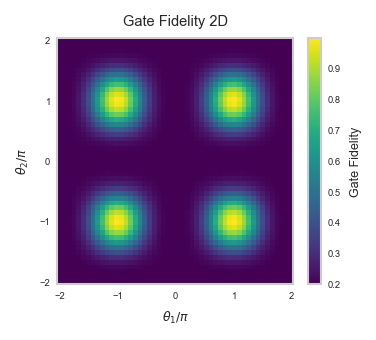

In [111]:
Theta_x, Theta_y = np.meshgrid(theta_list, theta_list)

plt.figure(figsize=(2.5, 2.25))
pcm = plt.pcolormesh(
    Theta_x / np.pi - 2,
    Theta_y / np.pi - 2,
    fidelity_geom_array,
    shading="auto",
    cmap="viridis"
)

plt.colorbar(pcm, label="Gate Fidelity")
plt.xlabel(r"$\theta_1/\pi$")
plt.xticks([-2,-1,0,1,2])
plt.ylabel(r"$\theta_2/\pi$")
plt.yticks([-2,-1,0,1,2])
plt.title("Gate Fidelity 2D")

plt.tight_layout()
plt.show()

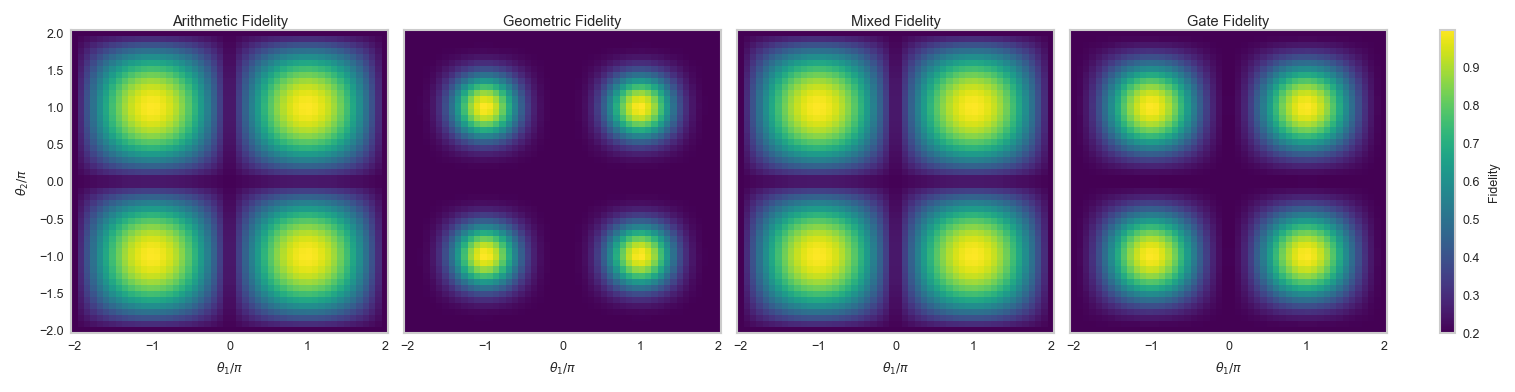

In [132]:
# meshgrid
Theta_x, Theta_y = np.meshgrid(theta_list / np.pi - 2, theta_list / np.pi - 2)

# ---- figure & axes ----
fig, axes = plt.subplots(
  1, 4,
  figsize=(10, 2.5),
  sharex=True,
  sharey=True,
  constrained_layout=True
)

fidelity_list = [
    fidelity_arith_array,
    fidelity_geom_array,
    fidelity_lambda_array,
    fidelity_gate_array
]

titles = [
    "Arithmetic Fidelity",
    "Geometric Fidelity",
    "Mixed Fidelity",
    "Gate Fidelity"
]

# 为了共用 colorbar，先确定统一范围（强烈推荐）
vmin = min(np.min(F) for F in fidelity_list)
vmax = max(np.max(F) for F in fidelity_list)

# ---- plot each panel ----
for ax, F, title in zip(axes.flat, fidelity_list, titles):
    pcm = ax.pcolormesh(
        Theta_x,
        Theta_y,
        F,
        shading="auto",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(title, pad=2)

# ---- axis labels（只给最外侧）----
axes[0].set_xlabel(r"$\theta_1/\pi$")
axes[1].set_xlabel(r"$\theta_1/\pi$")
axes[2].set_xlabel(r"$\theta_1/\pi$")
axes[3].set_xlabel(r"$\theta_1/\pi$")
axes[0].set_ylabel(r"$\theta_2/\pi$")

# ---- shared colorbar ----
cbar = fig.colorbar(
    pcm,
    ax=axes,
    fraction=0.03,   # 控制宽度（非常关键）
    pad=0.04
)
cbar.set_label("Fidelity")

# ---- layout ----
# fig.tight_layout(pad=0.6)
plt.show()